In [ ]:
# --- First cell for all notebooks: ---
# works locally and in Google Colab 

import sys
import os


# Detect if running in Google Colab
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    # Mount Google Drive in Colab
    from google.colab import drive
    drive.mount('/content/drive')
    
    # Set BASE_PATH assuming repo is cloned in Colab
    BASE_PATH = "/content/Real-Time-Anomaly-Detection-in-IoMT-AD-Project"
else:
    # Local environment: BASE_PATH = project root (three levels up from Models/Chaima/notebooks)
    BASE_PATH = os.path.abspath(os.path.join(os.getcwd(), "..", "..", ".."))

print(f"📁 BASE_PATH detected as: {BASE_PATH}")

# Add Models/Chaima folder to Python path for imports
sys.path.append(os.path.join(BASE_PATH, "Models", "Chaima"))
print("✅ PYTHONPATH updated. Models/Chaima folder included.")

# Load model + selected features + scaler + data

In [ ]:
import numpy as np
import pandas as pd
import json
from tensorflow.keras.models import load_model

# Load selected features
with open(os.path.join(BASE_PATH, "Spark/selected_features.json")) as f:
    sel = json.load(f)

# Load full validation set (scaled)
X_val_s = np.load(os.path.join(BASE_PATH, "Dataset/intermediate/X_val_s.npy"))

# Load raw val set to get labels
raw_val = pd.read_csv(os.path.join(BASE_PATH, "Dataset/raw/val.csv"))
val_labels = raw_val["label"].values

# Load list of all features
with open(os.path.join(BASE_PATH, "Dataset/intermediate/features.json")) as f:
    features = json.load(f)

# Select only chosen features
X_val_fs = X_val_s[:, [features.index(f) for f in sel]]

# Load autoencoder
model = load_model(os.path.join(BASE_PATH, "Models/Chaima/lstm_autoencoder.h5"), compile=False)


# Compute reconstruction errors

In [ ]:
X_val_lstm = np.expand_dims(X_val_fs, axis=1)
reconstructed = model.predict(X_val_lstm, verbose=0)

# Remove timestep dimension
reconstructed = reconstructed[:, 0, :]

# Reconstruction error (MSE per sample)
errors = np.mean(np.square(X_val_fs - reconstructed), axis=1)


# Separate benign vs attack

In [ ]:
benign_errors = errors[val_labels == "BenignTraffic"]
attack_errors = errors[val_labels != "BenignTraffic"]

print(len(benign_errors), len(attack_errors))


(27519, 1149332)

# Reconstruction Error Distribution Plots

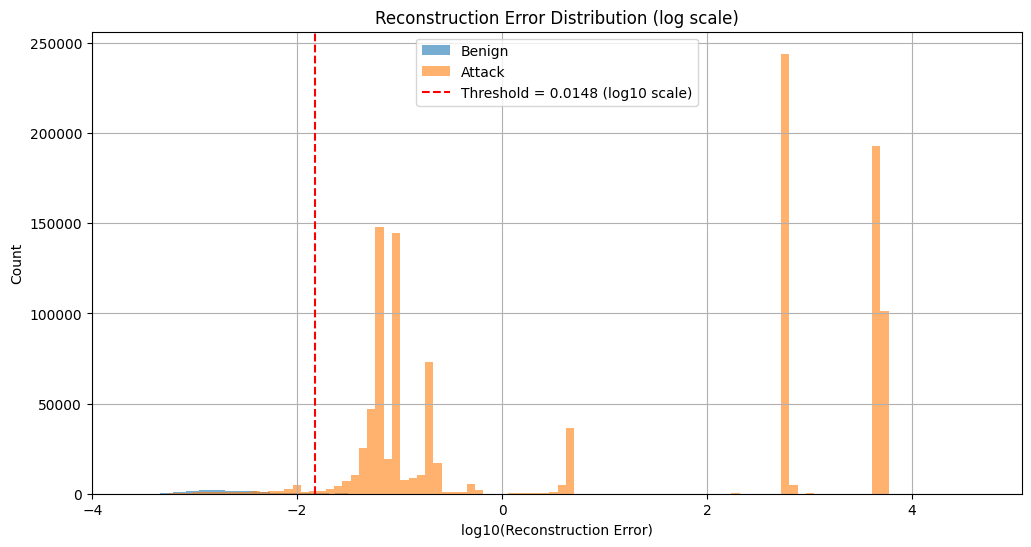

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Compute threshold (95th percentile of benign errors)
threshold = np.percentile(benign_errors, 95)

plt.figure(figsize=(12,6))

# Add a small epsilon to avoid log(0)
eps = 1e-8

plt.hist(np.log10(benign_errors + eps), bins=100, alpha=0.6, label="Benign")
plt.hist(np.log10(attack_errors + eps), bins=100, alpha=0.6, label="Attack")

plt.axvline(np.log10(threshold + eps), color="red", linestyle="--",
            label=f"Threshold = {threshold:.6f} (log10 scale)")

plt.title("Reconstruction Error Distribution (log scale)")
plt.xlabel("log10(Reconstruction Error)")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import json
with open(os.path.join(BASE_PATH, "Models/threshold.json"), "w") as f:
    json.dump({"threshold": float(threshold)}, f)


# Predict anomalies using threshold

In [ ]:
y_pred = (errors > threshold).astype(int)   # 1 = anomaly
y_true = (val_labels != "BenignTraffic").astype(int)


# Compute metrics

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

print("\nClassification Report:")
print(classification_report(y_true, y_pred))

print("\nROC-AUC:", roc_auc_score(y_true, errors))
print("PR-AUC:", average_precision_score(y_true, errors))


Confusion Matrix:
[[  26143    1376]
 [  22529 1126803]]

Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.95      0.69     27519
           1       1.00      0.98      0.99   1149332

    accuracy                           0.98   1176851
   macro avg       0.77      0.97      0.84   1176851
weighted avg       0.99      0.98      0.98   1176851


ROC-AUC: 0.9909470780796394
PR-AUC: 0.9997597610562877
